In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
import gc

from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

from envs.windy_gridworld import WindyGridworldEnv
from envs.gridworld import GridworldEnv
from models import PolicyNetwork, ValueNetwork

In [2]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def select_action(model, state, epoch, grid_shape, init_temperature=1.1):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    state = np.unravel_index(state, grid_shape)
    log_p = model(torch.FloatTensor(state))
    
    # Now add the temperature for making some exploration.
    decay_exploration_epochs = 50
    temperature = 1
    if epoch < decay_exploration_epochs:
        temperature = init_temperature - (init_temperature-temperature)*(epoch/decay_exploration_epochs)

    
    probs = log_p.div(temperature)
    probs = torch.exp(probs)
    probs = probs / torch.sum(probs)
    action = torch.multinomial(probs, 1).item()
        
    return action, log_p[action]

def run_episode(env, model, epoch, grid_shape):
    # YOUR CODE HERE
    episode = []
    
    s = env.reset()
    done = False
    step = 0
    max_steps = 50
    
    while not done and step<max_steps:
        
        a, log_p = select_action(model, s, epoch, grid_shape)
        s_next, r, done, _ = env.step(a)
        
        episode.append((s, a, log_p, s_next, r))
        s = s_next
        
        step += 1
          
    env.close()
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    discounted_return_list = []
    log_p_list = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        discounted_return_list.append(G)
        log_p_list.append(log_p)
    # Stacking the logs to a tensor.
    log_p_tensor = torch.stack(log_p_list)
    
    # Converting the returns to a tensor
    discounted_return_tensor = torch.FloatTensor(discounted_return_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_tensor)
    return loss

def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate, grid_shape):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    losses = []
    for i in range(num_episodes):
        
        optimizer.zero_grad()
        
        episode = run_episode(env, model, i, grid_shape)
        loss = compute_reinforce_loss(episode, discount_factor)
        
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
                           
#         if i % 10 == 0:
#             print("{2} Episode {0} finished after {1} steps"
#                   .format(i, len(episode), '\033[92m' if len(episode) <= 20 else '\033[99m'))
#             gc.collect()
          
        losses.append(loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(losses)

## REINFORCE NO BASELINE ON GRID-WORLD

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9
Done with run 10
Done with run 11
Done with run 12
Done with run 13
Done with run 14
Done with run 15
Done with run 16
Done with run 17
Done with run 18
Done with run 19
Done with run 20
Done with run 21
Done with run 22
Done with run 23
Done with run 24
Done with run 25
Done with run 26
Done with run 27
Done with run 28
Done with run 29
Done with run 30
Done with run 31
Done with run 32
Done with run 33
Done with run 34
Done with run 35
Done with run 36
Done with run 37
Done with run 38
Done with run 39
Done with run 40
Done with run 41
Done with run 42
Done with run 43
Done with run 44
Done with run 45
Done with run 46
Done with run 47
Done with run 48
Done with run 49


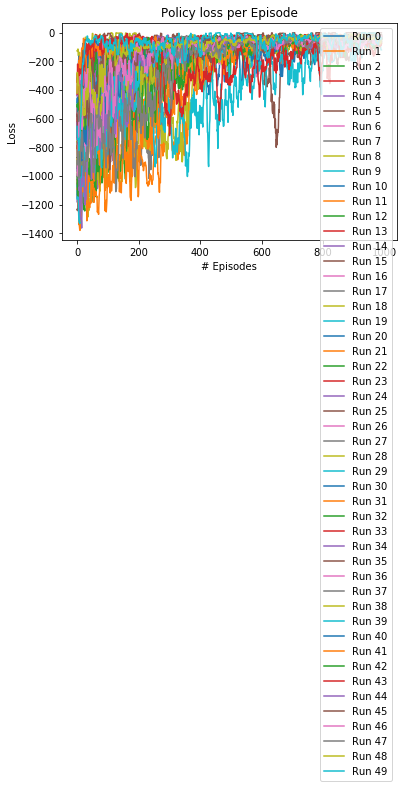

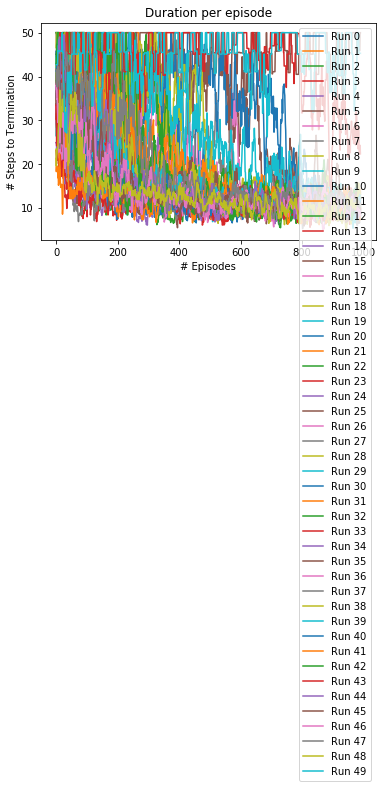

In [3]:
# Feel free to play around with the parameters!
num_runs = 50
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape=[10,10]

no_episode_lenghts = []
no_policy_losses = []

env = GridworldEnv(shape=grid_shape)

for i in range(num_runs):
    
    model = PolicyNetwork()
    seed = 40 + i
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations_policy_gradient, losses_policy_gradient = run_episodes_policy_gradient(model,
                                                                                             env,
                                                                                             num_episodes,
                                                                                             discount_factor,
                                                                                             learn_rate,
                                                                                             grid_shape)
    no_policy_losses.append(losses_policy_gradient)
    no_episode_lenghts.append(episode_durations_policy_gradient)
    del model
    print('Done with run {}'.format(i))
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(no_policy_losses[i], 10), label='Run {}'.format(i))
    plt.title('Policy loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()

plt.figure()    
for i in range(num_runs):    
    
    plt.plot(smooth(no_episode_lenghts[i],10), label='Run {}'.format(i))
    plt.title('Duration per episode')
    plt.xlabel('# Episodes')
    plt.ylabel('# Steps to Termination')
    plt.legend()

## REINFORCE LEARNED BASELINE (Value Network) ON GRID-WORLD

In [4]:
def run_episode(env, model, epoch, grid_shape):
    # YOUR CODE HERE
    episode = []
    
    s = env.reset()
    done = False
    step = 0
    max_steps = 50
    
    while not done and step<max_steps:
        
        a, log_p = select_action(model, s, epoch, grid_shape)
        s_next, r, done, _ = env.step(a)
        
        episode.append((s, a, log_p, s_next, r))
        s = s_next
        
        step += 1
          
    env.close()
    return episode

def compute_reinforce_loss_with_vNN_baseline(v_model, episode, discount_factor, grid_shape):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    discounted_return_with_baseline_list = []
    log_p_list = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        state = np.unravel_index(s, grid_shape)
        baseline = v_model(torch.FloatTensor(state))
        
        discounted_return_with_baseline_list.append(G-baseline)
        log_p_list.append(log_p)
    # Stacking the logs to a tensor.
    log_p_tensor = torch.stack(log_p_list)
    
    # Converting the returns to a tensor
    discounted_return_with_baseline_tensor = torch.FloatTensor(discounted_return_with_baseline_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_with_baseline_tensor)
    return loss

def compute_value_loss(v_model, episode, discount_factor, grid_shape):
    # Compute the value loss
    returns = []
    v_estimates = []
    G = 0
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        returns.append(G)
        
        state = np.unravel_index(s, grid_shape)
        v_estimates.append(v_model(torch.FloatTensor(state)))

    # Converting to a tensor
    v_estimates_tensor = torch.stack(v_estimates) 
    returns_tensor = torch.FloatTensor(returns)
    
    loss = torch.sum(torch.abs(returns_tensor - v_estimates_tensor))
    return loss

def run_episodes_policy_gradient_with_vNN_baseline(policy_model, v_model, env, num_episodes, discount_factor, learn_rate, grid_shape):
    
    policy_optimizer = optim.Adam(policy_model.parameters(), learn_rate)
    v_optimizer = optim.Adam(v_model.parameters(), learn_rate)
    
    episode_durations = []
    value_losses = []
    reinforce_losses = []
    for i in range(num_episodes):
        
        policy_optimizer.zero_grad()
        v_optimizer.zero_grad()
        
        episode = run_episode(env, policy_model, i, grid_shape)
        # The loss for policy network.
        reinforce_loss = compute_reinforce_loss_with_vNN_baseline(v_model, episode, discount_factor, grid_shape)
        # The loss for value network.
        value_loss = compute_value_loss(v_model, episode, discount_factor, grid_shape)
        
        reinforce_loss.backward()
        policy_optimizer.step()
        
        value_loss.backward()
        v_optimizer.step()
                           
        reinforce_losses.append(reinforce_loss.detach().numpy())
        value_losses.append(value_loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(reinforce_losses), np.asanyarray(value_losses)

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9
Done with run 10
Done with run 11
Done with run 12
Done with run 13
Done with run 14
Done with run 15
Done with run 16
Done with run 17
Done with run 18
Done with run 19
Done with run 20
Done with run 21
Done with run 22
Done with run 23
Done with run 24
Done with run 25
Done with run 26
Done with run 27
Done with run 28
Done with run 29
Done with run 30
Done with run 31
Done with run 32
Done with run 33
Done with run 34
Done with run 35
Done with run 36
Done with run 37
Done with run 38
Done with run 39
Done with run 40
Done with run 41
Done with run 42
Done with run 43
Done with run 44
Done with run 45
Done with run 46
Done with run 47
Done with run 48
Done with run 49


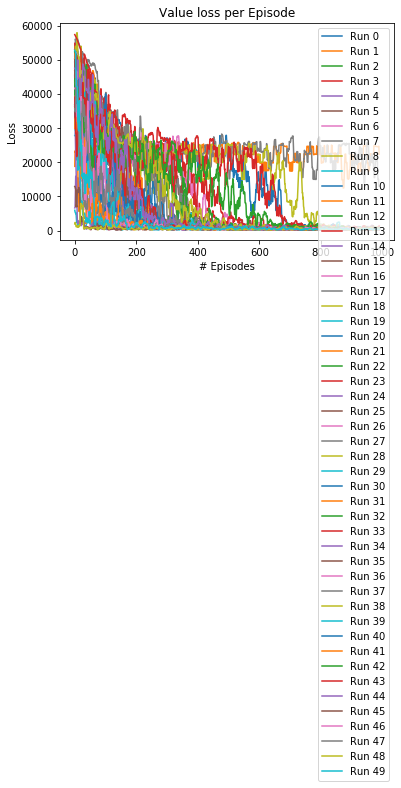

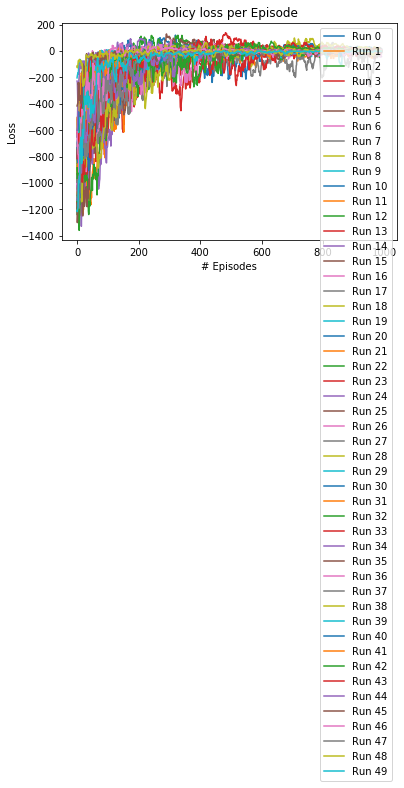

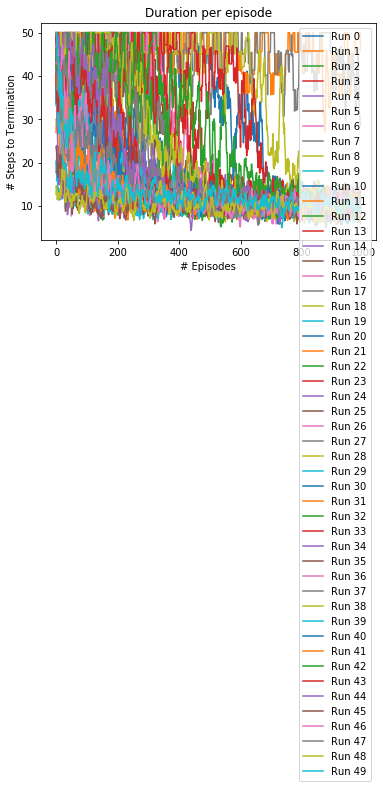

In [10]:
# Feel free to play around with the parameters!
num_runs = 50
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape=[10,10]

lb_vNN_episode_lenghts = []
lb_vNN_value_losses = []
lb_vNN_policy_losses = []

env = GridworldEnv(shape=grid_shape)

for i in range(num_runs):
    
    policy_model = PolicyNetwork()
    value_model = ValueNetwork()
    seed = 40 + i
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations_policy_gradient, \
    policy_losses_policy_gradient, \
    value_losses_value_gradient = run_episodes_policy_gradient_with_vNN_baseline(policy_model,
                                                                                 value_model,
                                                                                 env,
                                                                                 num_episodes,
                                                                                 discount_factor,
                                                                                 learn_rate,
                                                                                 grid_shape)
    
    lb_vNN_policy_losses.append(policy_losses_policy_gradient)
    lb_vNN_value_losses.append(value_losses_value_gradient)
    lb_vNN_episode_lenghts.append(episode_durations_policy_gradient)
    
    del policy_model
    del value_model
    print('Done with run {}'.format(i))
    
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(lb_vNN_value_losses[i], 10), label='Run {}'.format(i))
    plt.title('Value loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(lb_vNN_policy_losses[i], 10), label='Run {}'.format(i))
    plt.title('Policy loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()

plt.figure()    
for i in range(num_runs):    
    
    plt.plot(smooth(lb_vNN_episode_lenghts[i],10), label='Run {}'.format(i))
    plt.title('Duration per episode')
    plt.xlabel('# Episodes')
    plt.ylabel('# Steps to Termination')
    plt.legend()

## REINFORCE SELF-CRITICAL greedy-return BASELINE ON GRID-WORLD

In [6]:
def sample_greedy_return_from_s(model, env, s, discount_factor, grid_shape):
    
    _ = env.reset()
    done = False
    step = 0
    max_steps = 50
    greedy_return = 0
    
    env.s = s
    
    while not done and step<max_steps:
        
        state = np.unravel_index(s, grid_shape)
        log_p_baseline = model(torch.FloatTensor(state))
        _, greedy_a =  log_p_baseline.max(0)
        greedy_a = greedy_a.item()
        
        s, reward, done, _ = env.step(greedy_a)
        
        greedy_return = reward + discount_factor * greedy_return
        
        step += 1

    env.close()
    return greedy_return

def compute_reinforce_loss_with_SC_greedy_return_baseline(model, episode, discount_factor, grid_shape, env):    
    discounted_return_with_baseline_list = []
    log_p_list = []
    G = 0
    
    model.eval()
    
    # We go over the episode and get the rewards and log_ps.
    for s, a, log_p, s_next, reward in reversed(episode):
        G = reward + discount_factor * G
        
        baseline = sample_greedy_return_from_s(model, env, s, discount_factor, grid_shape)
        discounted_return_with_baseline_list.append(G - baseline)
        log_p_list.append(log_p)
        
    model.train()
    
    # Stacking the log-probabilities to a tensor.
    log_p_tensor = torch.stack(log_p_list)
    
    # Converting the returns to a tensor
    discounted_return_with_baseline_tensor = torch.FloatTensor(discounted_return_with_baseline_list)
    
    loss = - torch.sum(log_p_tensor * discounted_return_with_baseline_tensor)
    return loss


def run_episodes_policy_gradient_with_SC_greedy_return_baseline(model, env, num_episodes, discount_factor, learn_rate, grid_shape):
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    losses = []
    
    for i in range(num_episodes):
        
        optimizer.zero_grad()
        
        episode = run_episode(env, model, i, grid_shape)
        loss = compute_reinforce_loss_with_SC_greedy_return_baseline(model, episode, discount_factor, grid_shape, env)
        
        loss.backward()
        optimizer.step()
          
        losses.append(loss.detach().numpy())
        episode_durations.append(len(episode))
    
        del episode
        
    return np.asanyarray(episode_durations), np.asanyarray(losses)

Done with run 0
Done with run 1
Done with run 2
Done with run 3
Done with run 4
Done with run 5
Done with run 6
Done with run 7
Done with run 8
Done with run 9
Done with run 10
Done with run 11
Done with run 12
Done with run 13
Done with run 14
Done with run 15
Done with run 16
Done with run 17
Done with run 18
Done with run 19
Done with run 20
Done with run 21
Done with run 22
Done with run 23
Done with run 24
Done with run 25
Done with run 26
Done with run 27
Done with run 28
Done with run 29
Done with run 30
Done with run 31
Done with run 32
Done with run 33
Done with run 34
Done with run 35
Done with run 36
Done with run 37
Done with run 38
Done with run 39
Done with run 40
Done with run 41
Done with run 42
Done with run 43
Done with run 44
Done with run 45
Done with run 46
Done with run 47
Done with run 48
Done with run 49


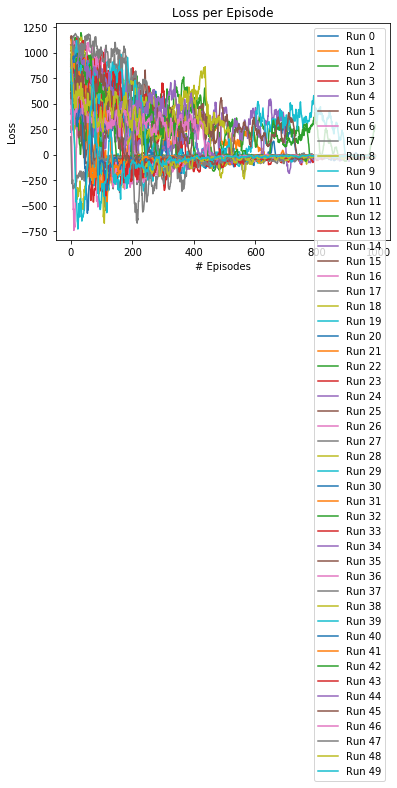

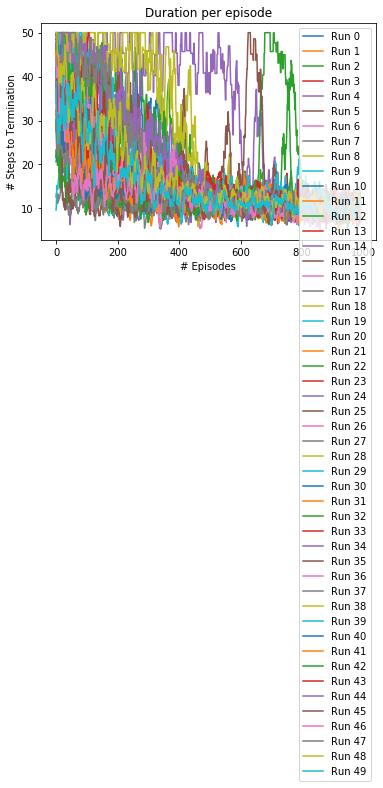

In [7]:
# Feel free to play around with the parameters!
num_runs = 50
num_episodes = 1000
discount_factor = 0.99
learn_rate = 0.001
grid_shape=[10,10]

sc_greedy_return_episode_lenghts = []
sc_greedy_return_losses = []

env = GridworldEnv(shape=grid_shape)

for i in range(num_runs):
    
    model = PolicyNetwork()
    seed = 40 + i
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    episode_durations_policy_gradient, losses_policy_gradient = run_episodes_policy_gradient_with_SC_greedy_return_baseline(model,
                                                                            env,
                                                                            num_episodes,
                                                                            discount_factor,
                                                                            learn_rate,
                                                                            grid_shape)
    
    sc_greedy_return_episode_lenghts.append(episode_durations_policy_gradient)
    sc_greedy_return_losses.append(losses_policy_gradient)
    
    del model
    
    print('Done with run {}'.format(i))
    
    
plt.figure()
for i in range(num_runs):
    plt.plot(smooth(sc_greedy_return_losses[i], 10), label='Run {}'.format(i))
    plt.title('Loss per Episode')
    plt.xlabel('# Episodes')
    plt.ylabel('Loss')
    plt.legend()

plt.figure()    
for i in range(num_runs):    
    
    plt.plot(smooth(sc_greedy_return_episode_lenghts[i],10), label='Run {}'.format(i))
    plt.title('Duration per episode')
    plt.xlabel('# Episodes')
    plt.ylabel('# Steps to Termination')
    plt.legend()

## COMPARISON

### Policy Loss
THIS IS CURRENTLY NOT COMPARBABLE AS THE BASELINE METHOD SUBSTRACTS THE BASELINE SO THE METRICS ARE NOT THE SAME... BUT CAN BE FIXED.

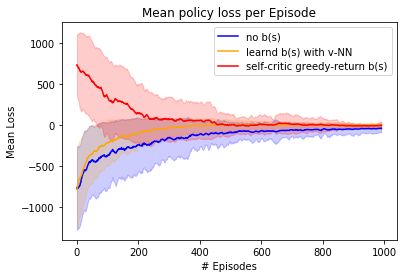

In [8]:
mean_sc_greedy_return_losses = np.mean(sc_greedy_return_losses, axis=0)
std_sc_greedy_return_losses = np.std(sc_greedy_return_losses, axis=0)

mean_lb_vNN_policy_losses = np.mean(lb_vNN_policy_losses, axis=0)
std_lb_vNN_policy_losses = np.std(lb_vNN_policy_losses, axis=0)

mean_no_policy_losses = np.mean(no_policy_losses, axis=0)
std_no_policy_losses = np.std(no_policy_losses, axis=0)

plt.figure()

plt.plot(smooth(mean_no_policy_losses, 10), label='no b(s)', c='blue')
plt.plot(smooth(mean_lb_vNN_policy_losses, 10), label='learnd b(s) with v-NN', c='orange')
plt.plot(smooth(mean_sc_greedy_return_losses, 10), label='self-critic greedy-return b(s)', c='red')

plt.fill_between(range(len(smooth(mean_no_policy_losses, 10))),
                 smooth(mean_no_policy_losses, 10) - smooth(std_no_policy_losses, 10),
                 smooth(mean_no_policy_losses, 10) + smooth(std_no_policy_losses, 10),
                 color='blue', alpha=0.2)

plt.fill_between(range(len(smooth(mean_lb_vNN_policy_losses, 10))),
                 smooth(mean_lb_vNN_policy_losses, 10) - smooth(std_lb_vNN_policy_losses, 10),
                 smooth(mean_lb_vNN_policy_losses, 10) + smooth(std_lb_vNN_policy_losses, 10),
                 color='orange', alpha=0.2)

plt.fill_between(range(len(smooth(mean_sc_greedy_return_losses, 10))),
                 smooth(mean_sc_greedy_return_losses, 10) - smooth(std_sc_greedy_return_losses, 10),
                 smooth(mean_sc_greedy_return_losses, 10) + smooth(std_sc_greedy_return_losses, 10),
                 color='red', alpha=0.2)

plt.title('Mean policy loss per Episode')
plt.xlabel('# Episodes')
plt.ylabel('Mean Loss')
plt.legend()

### Episode Length

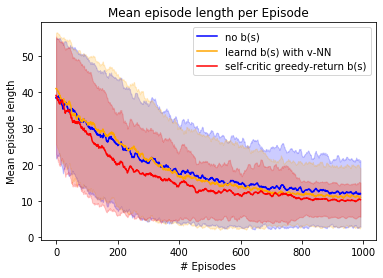

In [11]:
mean_sc_greedy_return_episode_lenghts = np.mean(sc_greedy_return_episode_lenghts, axis=0)
std_sc_greedy_return_episode_lenghts = np.std(sc_greedy_return_episode_lenghts, axis=0)

mean_lb_vNN_episode_lenghts = np.mean(lb_vNN_episode_lenghts, axis=0)
std_lb_vNN_episode_lenghts = np.std(lb_vNN_episode_lenghts, axis=0)

mean_no_episode_lenghts = np.mean(no_episode_lenghts, axis=0)
std_no_episode_lenghts = np.std(no_episode_lenghts, axis=0)

plt.figure()
plt.plot(smooth(mean_no_episode_lenghts, 10), label='no b(s)', c='blue')
plt.plot(smooth(mean_lb_vNN_episode_lenghts, 10), label='learnd b(s) with v-NN', c='orange')
plt.plot(smooth(mean_sc_greedy_return_episode_lenghts, 10), label='self-critic greedy-return b(s)', c='red')

plt.fill_between(range(len(smooth(mean_no_episode_lenghts, 10))),
                 smooth(mean_no_episode_lenghts, 10) - smooth(std_no_episode_lenghts, 10),
                 smooth(mean_no_episode_lenghts, 10) + smooth(std_no_episode_lenghts, 10),
                 color='blue', alpha=0.2)

plt.fill_between(range(len(smooth(mean_lb_vNN_episode_lenghts, 10))),
                 smooth(mean_lb_vNN_episode_lenghts, 10) - smooth(std_lb_vNN_episode_lenghts, 10),
                 smooth(mean_lb_vNN_episode_lenghts, 10) + smooth(std_lb_vNN_episode_lenghts, 10),
                 color='orange', alpha=0.2)

plt.fill_between(range(len(smooth(mean_sc_greedy_return_episode_lenghts, 10))),
                 smooth(mean_sc_greedy_return_episode_lenghts, 10) - smooth(std_sc_greedy_return_episode_lenghts, 10),
                 smooth(mean_sc_greedy_return_episode_lenghts, 10) + smooth(std_sc_greedy_return_episode_lenghts, 10),
                 color='red', alpha=0.2)

plt.title('Mean episode length per Episode')
plt.xlabel('# Episodes')
plt.ylabel('Mean episode length')
plt.legend()